# Exploratory Data Analysis Notebook

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams['font.family'] = 'times'

In [39]:
measurements = ['T2',        # [°R]       Total temperature at fan inlet
                'T24',       # [°R]       Total temperature at LPC outlet
                'T30',       # [°R]       Total temperature at HPC outlet
                'T50',       # [°R]       Total temperature at LPT outlet
                'P2',        # [psia]     Pressure at fan inlet
                'P15',       # [psia]     Total pressure in bypass-duct
                'P30',       # [psia]     Total pressure at HPC outlet
                'Nf',        # [rpm]      Physical fan speed
                'Nc',        # [rpm]      Physical core speed
                'epr',       # [-]        Engine pressure ratio (P50/P2)
                'Ps30',      # [psia]     Static pressure at HPC outlet
                'phi',       # [pps/psi]  Ratio of fuel flow to Ps30
                'NRf',       # [rpm]      Corrected fan speed
                'NRc',       # [rpm]      Corrected core speed
                'BPR',       # [-]        Bypass Ratio
                'farB',      # [-]        Burner fuel-air ratio
                'htBleed',   # [-]        Bleed Enthalpy
                'Nf_dmd',    # [rpm]      Demanded fan speed
                'PCNfR_dmd', # [rpm]      Demanded corrected fan speed
                'W31',       # [lbm/s]    HPT coolant bleed
                'W32']       # [lbm/s]    LPT coolant bleed 

settings = ['setting1', 'setting2', 'setting3']

In [40]:
# Read the .txt file
data = pd.read_csv('CMAPSSData/train_FD004.txt', header = None, sep = ' ')
# Rename the columns approprietly
data.columns = ['unitNumber', 'timeCycles'] + settings + measurements + ['drop1', 'drop2']
# Drop the two NaN columns
data = data.drop(columns = ['drop1', 'drop2'])
data.head()

,unitNumber,timeCycles,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


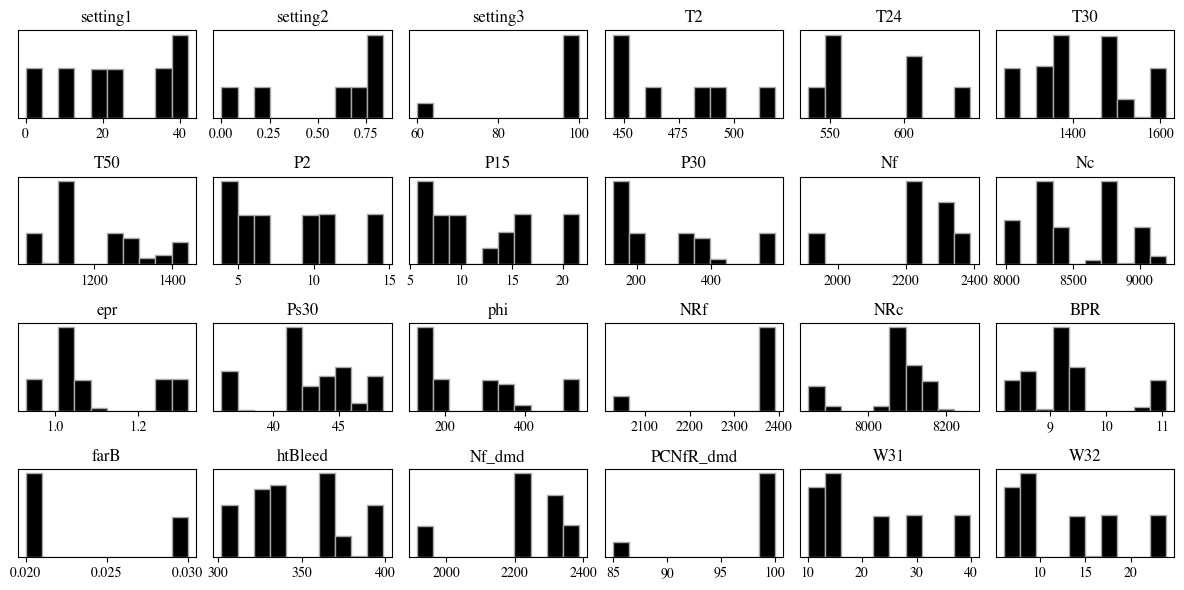

In [41]:
fig, ax = plt.subplots(4, 6, figsize = (12, 6)); ax = ax.flatten()
for i, feature in enumerate(settings + measurements) :

    ax[i].hist(data[feature], color = 'k', edgecolor = 'darkgrey')
    ax[i].set_title(feature)
    ax[i].set_yticks([])

plt.tight_layout(w_pad = 0.01)
plt.show()

In [36]:
# Print list of constant features
constantFeatures = [] # This feature is constant + some corrupted/outliers values
for feature in settings + measurements :
    if data[feature].min() == data[feature].max() :
        print(feature)
        constantFeatures.append(feature)

data = data.drop(columns = constantFeatures)
settings = [sett for sett in settings if sett not in constantFeatures]
measurements = [meas for meas in measurements if meas not in constantFeatures]

setting3
T2
P2
farB
Nf_dmd
PCNfR_dmd


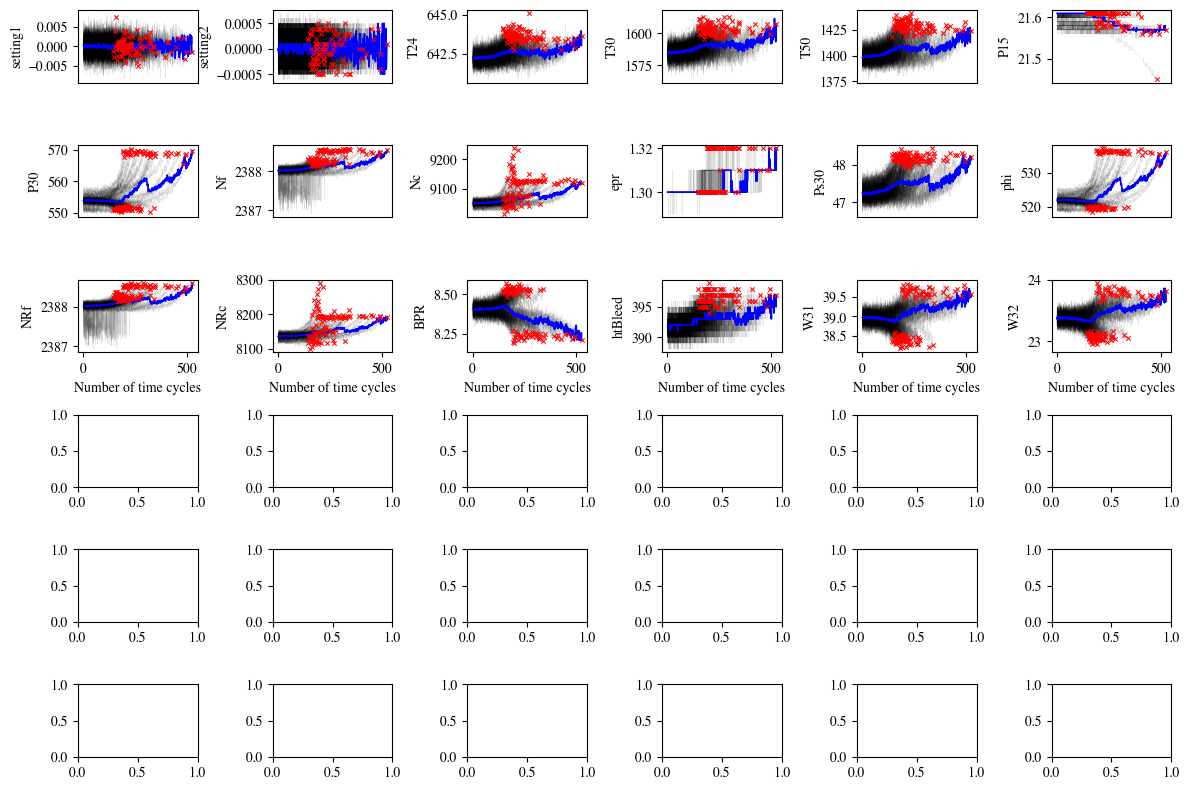

In [37]:
data_mean = data.groupby('timeCycles').median(settings + measurements).reset_index()

fig, ax = plt.subplots(6, 6, figsize = (12, 8)); ax = ax.flatten()

for i, feature in enumerate(settings + measurements) :
    ax[i].plot(data_mean['timeCycles'], data_mean[feature], c = 'blue', linewidth = 1.2, zorder = 0)
    for unit in list(data['unitNumber'].unique()) :
        dataUnit = data.groupby('unitNumber').get_group(unit)
        ax[i].plot(dataUnit['timeCycles'], dataUnit[feature], c = 'k', alpha = 0.1, linewidth = 0.4, zorder = -1)
        ax[i].scatter(dataUnit['timeCycles'].tail(1), dataUnit[feature].tail(1), c = 'red', marker = 'x', s = 10, zorder = 1, linewidth = 0.75)
    ax[i].set_ylabel(feature)   
    if i < 12 :
        ax[i].set_xticks([])
    else :
        ax[i].set_xlabel('Number of time cycles')     

plt.tight_layout(w_pad = 0.01)
plt.show()

In [31]:
RULs = data.groupby('unitNumber')['timeCycles'].max().reset_index().rename(columns = {'timeCycles': 'failTime'})
data = data.merge(RULs, on = 'unitNumber', how = 'left')
data['RUL'] = data['failTime'] - data['timeCycles']
data = data.drop(columns = ['failTime'])
data.head()

,unitNumber,timeCycles,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071,148
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665,147
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723,146
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701,145
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286,144


In [41]:
# Export data
data.to_csv('Predictive Phase/processed_data.csv', index = None)

/Users/martinbogaert/anaconda3/envs/nbaenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


IndexError: index 18 is out of bounds for axis 0 with size 18

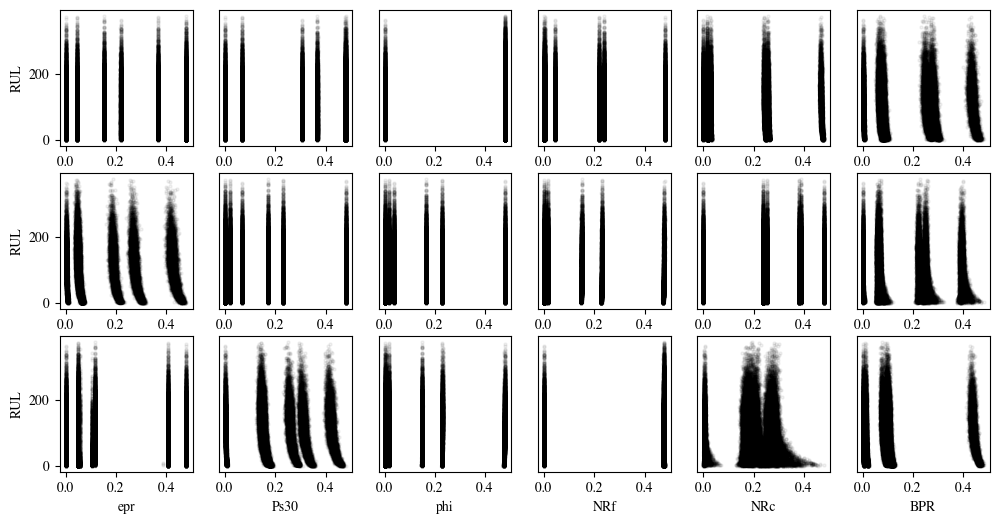

In [32]:
fig, ax = plt.subplots(3, 6, figsize = (12, 6)); ax = ax.flatten()

xs = np.linspace(0, 1, 1000)
for i, feature in enumerate(settings + measurements) :
    x, y = data[feature], data['RUL']
    x_norm = (x - x.min()) / (x.max() - x.min())
    ax[i].scatter(np.log(x_norm + 1) ** 2,  y, alpha = 0.05, c = 'k', s = 5)
    m, n = np.polyfit(x_norm, y, 1)
    a, b, c = np.polyfit(x_norm, y, 2)
  #  ax[i].plot(xs, m * xs + n)
   # ax[i].plot(xs, a * xs**2 + b * xs + c)
    ax[i].set_xlabel(feature)
    if i % 6 == 0:
        ax[i].set_ylabel('RUL')
    else :
        ax[i].set_yticks([])
ax[-2].set_yticks([]); ax[-1].set_yticks([])

plt.tight_layout()
plt.show()

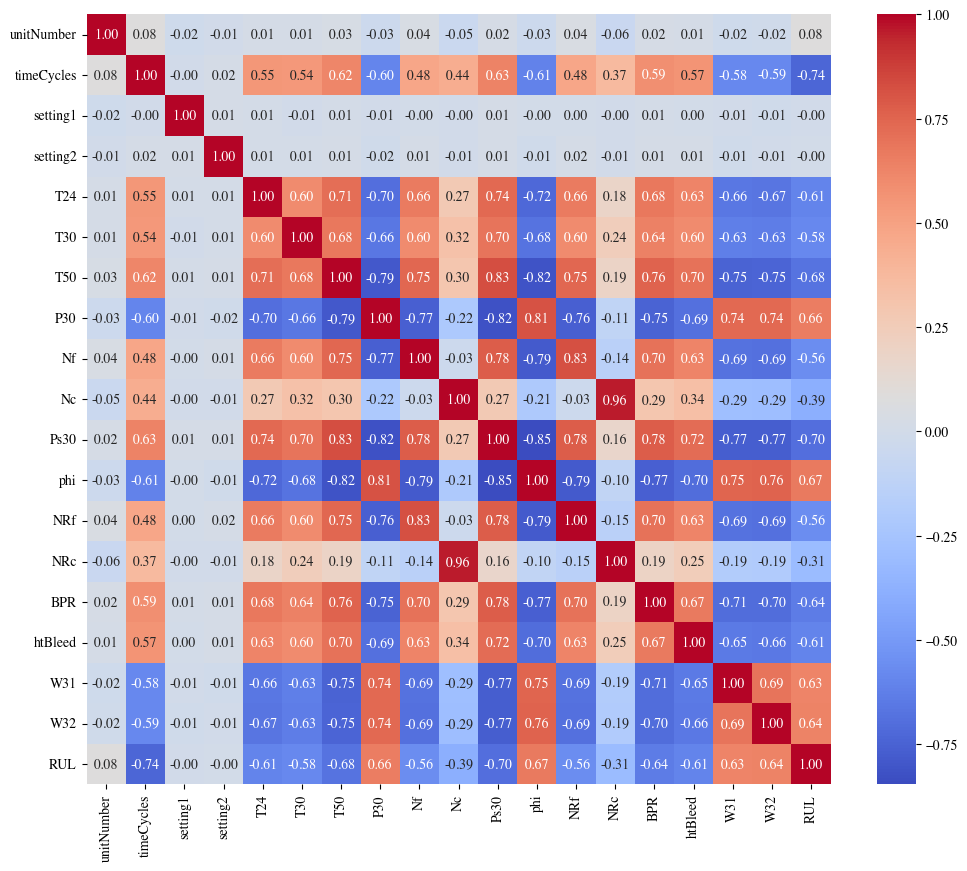

In [43]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

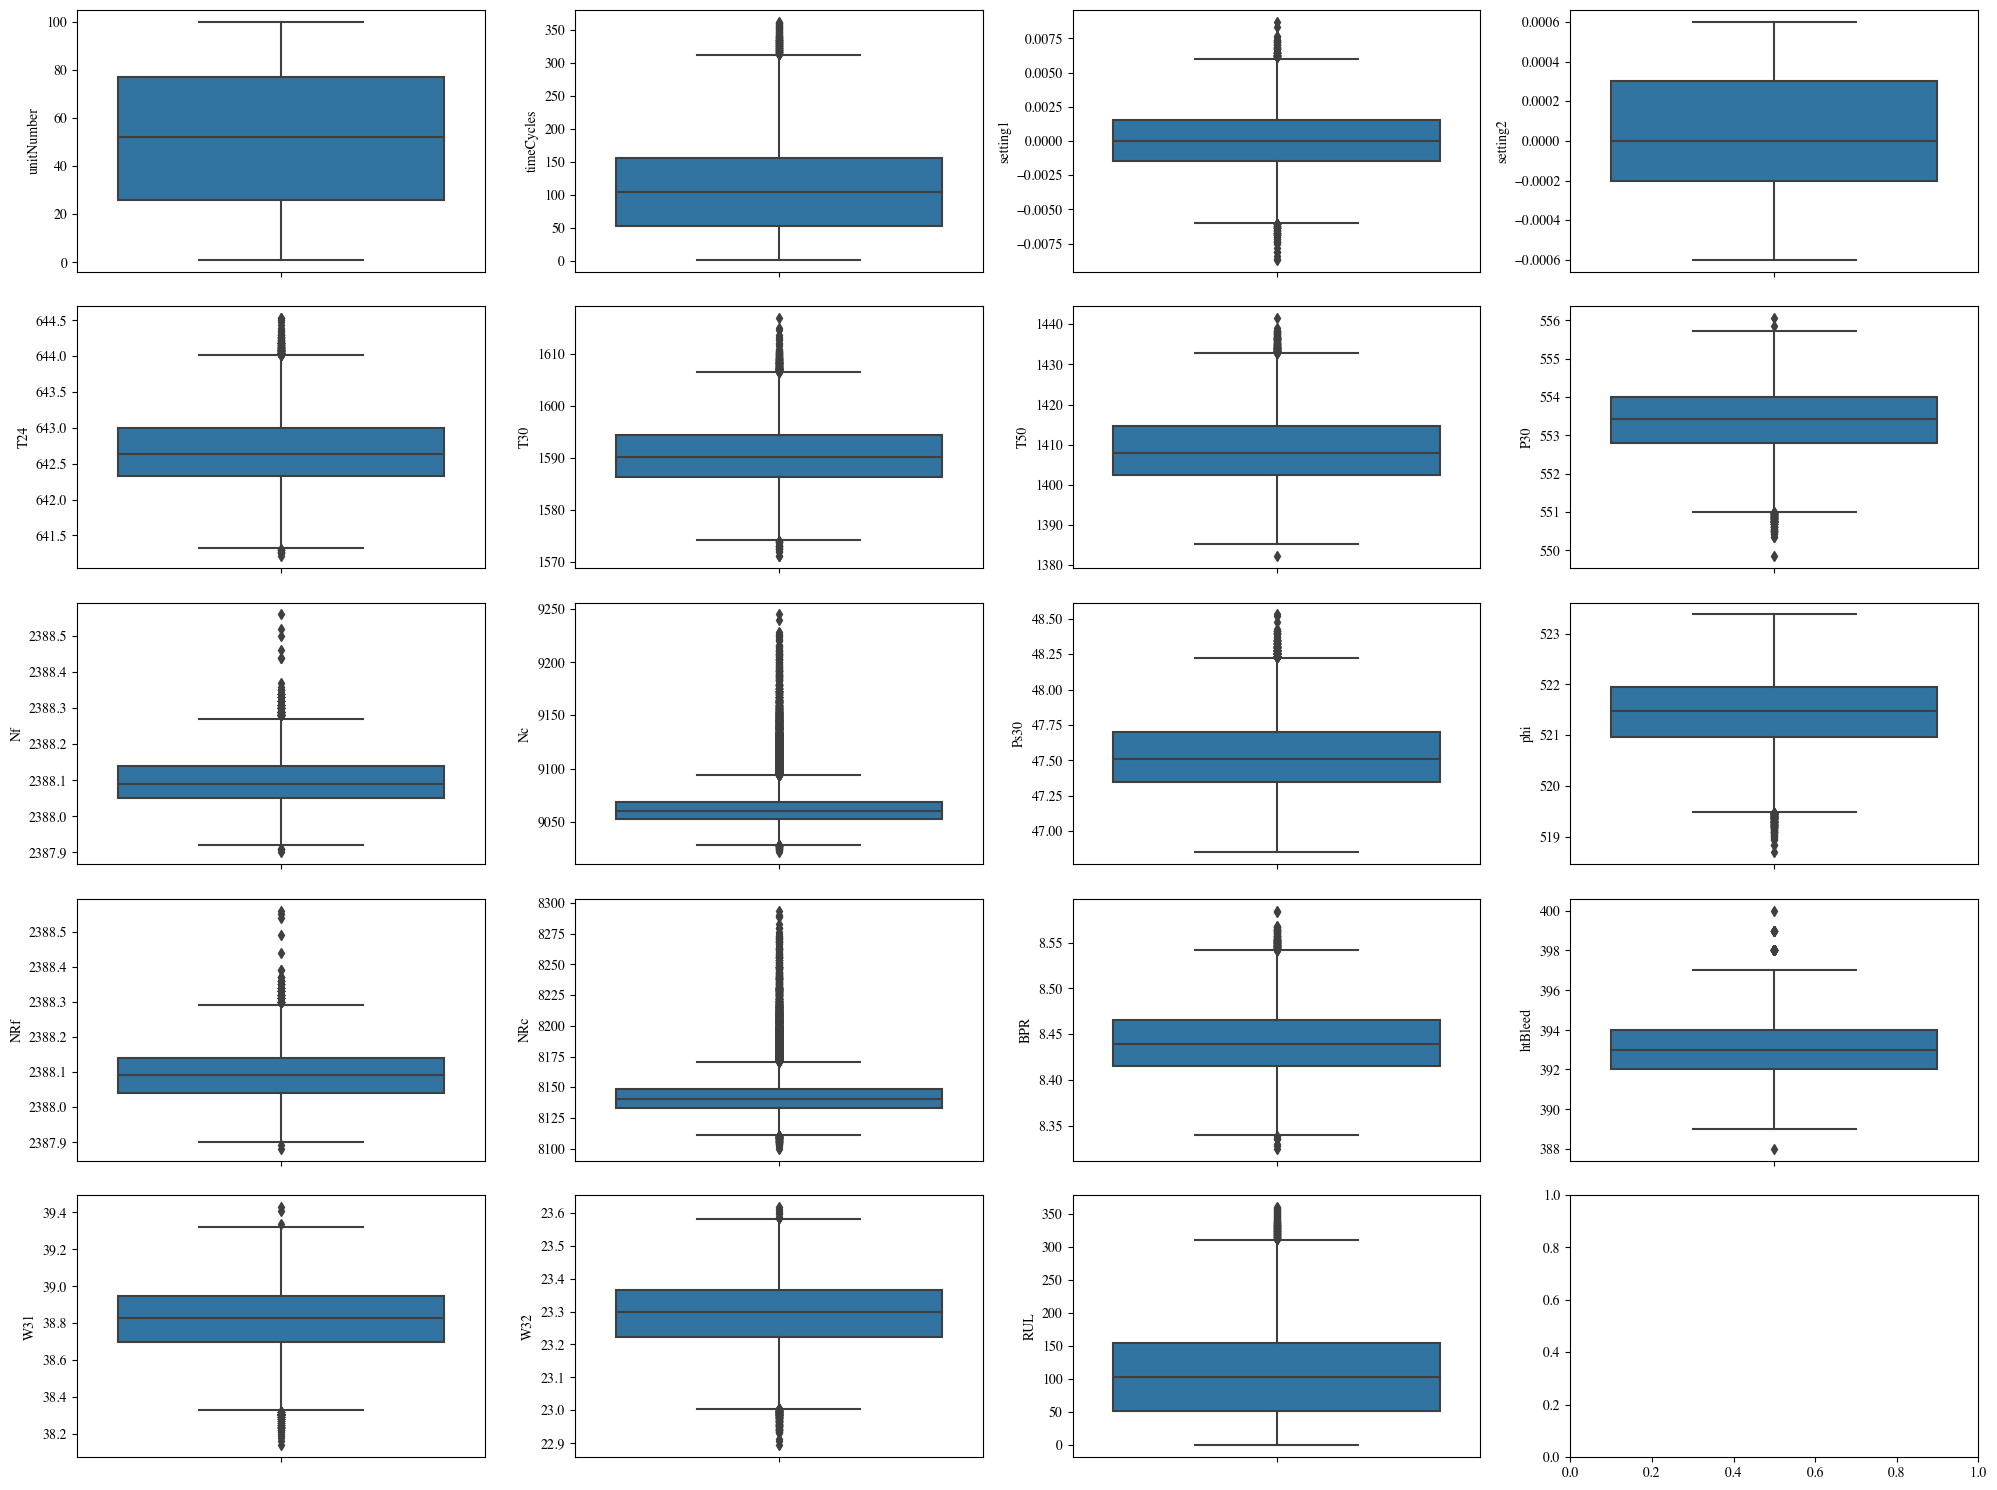

In [44]:
# Box plots for each feature
fig, ax = plt.subplots(5, 4, figsize=(20, 15)) # Adjust the size and layout as needed
ax = ax.flatten()
for i, col in enumerate(data.columns):
    sns.boxplot(y=col, data=data, ax=ax[i])
plt.tight_layout()
plt.show()


In [45]:
# Percentage of missing values for each feature
missing_percentage = data.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]
print(missing_percentage.sort_values(ascending=False))


Series([], dtype: float64)


In [76]:
xs = np.linspace(0, 1, 1000)
y = 0.1 * xs ** 2 + 0.5
yp = y + np.random.normal(0, .01, y.shape)

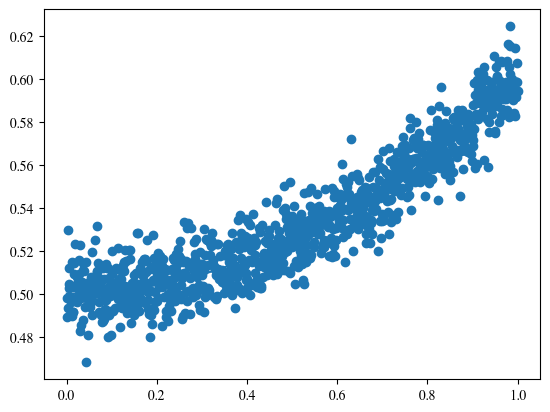

In [77]:
plt.plot(xs, y)
plt.scatter(xs, yp)

In [79]:
np.polyfit(xs, yp, 2)

array([ 0.10719304, -0.00919838,  0.50244509])